In [9]:
# --- 1. PREPARAÇÃO DO AMBIENTE ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- 2. CARGA DOS DADOS ---
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)

# Vamos manter o dataframe original salvo para comparações
df_original = df.copy()

# Removendo colunas que não usaremos de forma alguma (identificadores)
df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

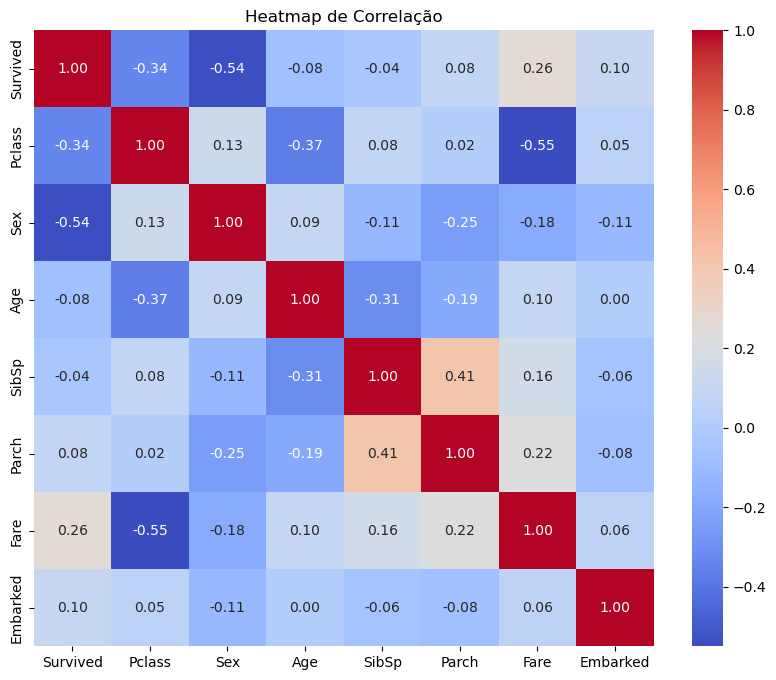

In [10]:
# --- 3. ANÁLISE DE REDUNDÂNCIA ---

# Para calcular a correlação, precisamos que as variáveis sejam numéricas.
# Vamos fazer uma conversão temporária das categóricas apenas para o heatmap.
df_temp = df.copy()

# Vamos remover a coluna 'Cabin' que contém texto e não pode ser usada na correlação.
df_temp.drop('Cabin', axis=1, inplace=True)
# --------------------

df_temp['Sex'] = df_temp['Sex'].map({'male': 1, 'female': 0})
df_temp['Embarked'] = pd.factorize(df_temp['Embarked'])[0]

# Agora o código do heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_temp.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap de Correlação')
plt.show()

In [11]:
#--- 3.1 Inconsistência ---
# A coluna Cabin tem muitos dados faltantes, vamos removê-la
df.drop('Cabin', axis=1, inplace=True)

In [12]:
# --- 4. DIVISÃO DOS DADOS ---

# É fundamental dividir os dados em treino e teste ANTES de aplicar a imputação 
# de dados ausentes e o balanceamento de classes. Isso evita o vazamento de dados (data leakage)

# Separando features (X) e alvo (y)
X = df.drop('Survived', axis=1)
y = df['Survived']

# Primeiro, vamos transformar as variáveis categóricas em numéricas
X = pd.get_dummies(X, columns=['Sex', 'Embarked'], drop_first=True)

# Agora sim, dividimos em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Formato dos dados de treino:", X_train.shape)
print("Formato dos dados de teste:", X_test.shape)

Formato dos dados de treino: (712, 8)
Formato dos dados de teste: (179, 8)


In [13]:
# --- 5. IMPUTAÇÃO DE DADOS AUSENTES ---
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# aplicar os métodos de imputação apenas no conjunto de treino e usar o 
# imputer treinado para transformar o conjunto de teste.

# Vamos criar cópias para testar cada método
X_train_knn, X_test_knn = X_train.copy(), X_test.copy()
X_train_mf, X_test_mf = X_train.copy(), X_test.copy()

# --- Método 1: KNNImputer ---
print("\n--- Imputação com KNNImputer ---")
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Treina no conjunto de treino e transforma ambos
X_train_knn['Age'] = knn_imputer.fit_transform(X_train[['Age']])
X_test_knn['Age'] = knn_imputer.transform(X_test[['Age']])
print("Valores nulos em 'Age' (treino) após KNN:", X_train_knn['Age'].isnull().sum())


# --- Método 2: MissForest (usando IterativeImputer do Scikit-learn) ---
# O IterativeImputer com um RandomForestRegressor é a implementação análoga ao MissForest
print("\n--- Imputação com MissForest (IterativeImputer) ---")
mf_imputer = IterativeImputer(estimator=RandomForestRegressor(), initial_strategy='mean',
                              max_iter=10, random_state=42)

# O IterativeImputer funciona melhor com todas as colunas
X_train_mf = pd.DataFrame(mf_imputer.fit_transform(X_train), columns=X_train.columns)
X_test_mf = pd.DataFrame(mf_imputer.transform(X_test), columns=X_test.columns)
print("Valores nulos em 'Age' (treino) após MissForest:", X_train_mf['Age'].isnull().sum())

# prosseguir usando os dados do MissForest (X_train_mf, X_test_mf), pois ele costuma gerar resultados mais robustos.


--- Imputação com KNNImputer ---
Valores nulos em 'Age' (treino) após KNN: 0

--- Imputação com MissForest (IterativeImputer) ---
Valores nulos em 'Age' (treino) após MissForest: 0


c:\Users\vitor\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [14]:
# --- 6. BALANCEAMENTO DE CLASSES ---
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# aplicar as técnicas de balanceamento nos dados de treino que já tiveram seus valores ausentes imputados (X_train_mf).

print("\n--- Balanceamento de Classes ---")
print("Distribuição original (treino):")
print(y_train.value_counts())

# --- Método 1: Undersampling (RandomUnderSampler) ---
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train_mf, y_train)
print("\nDistribuição após Undersampling:")
print(y_train_under.value_counts())

# --- Método 2: Oversampling (SMOTE) ---
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train_mf, y_train)
print("\nDistribuição após Oversampling (SMOTE):")
print(y_train_over.value_counts())


--- Balanceamento de Classes ---
Distribuição original (treino):
Survived
0    439
1    273
Name: count, dtype: int64

Distribuição após Undersampling:
Survived
0    273
1    273
Name: count, dtype: int64

Distribuição após Oversampling (SMOTE):
Survived
1    439
0    439
Name: count, dtype: int64


In [15]:
# --- 7. TREINAMENTO E AVALIAÇÃO FINAL ---

# Treinar o RandomForestClassifier em três cenários diferentes 
# e comparar os resultados no mesmo conjunto de teste (X_test_mf, y_test)

# Reutilizando a função de avaliação
def evaluate_model(model_name, y_true, y_pred):
    """Função para exibir as métricas de avaliação de forma organizada."""
    print(f"--- Avaliação do Modelo: {model_name} ---")
    
    # Acurácia Geral
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Acurácia Geral: {accuracy:.4f}\n")
    
    # Relatório de Classificação (com métricas por classe)
    print("Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=['Não Sobreviveu (0)', 'Sobreviveu (1)']))
    
    # Matriz de Confusão
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Não Sobreviveu', 'Sobreviveu'], 
                yticklabels=['Não Sobreviveu', 'Sobreviveu'])
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.show()

--- Avaliação do Modelo: Random Forest (Desbalanceado) ---
Acurácia Geral: 0.7989

Relatório de Classificação:
                    precision    recall  f1-score   support

Não Sobreviveu (0)       0.82      0.85      0.84       110
    Sobreviveu (1)       0.75      0.71      0.73        69

          accuracy                           0.80       179
         macro avg       0.79      0.78      0.79       179
      weighted avg       0.80      0.80      0.80       179



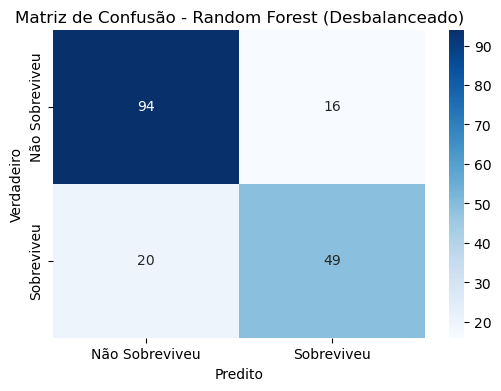

--- Avaliação do Modelo: Random Forest (Undersampling) ---
Acurácia Geral: 0.7709

Relatório de Classificação:
                    precision    recall  f1-score   support

Não Sobreviveu (0)       0.83      0.78      0.81       110
    Sobreviveu (1)       0.68      0.75      0.72        69

          accuracy                           0.77       179
         macro avg       0.76      0.77      0.76       179
      weighted avg       0.78      0.77      0.77       179



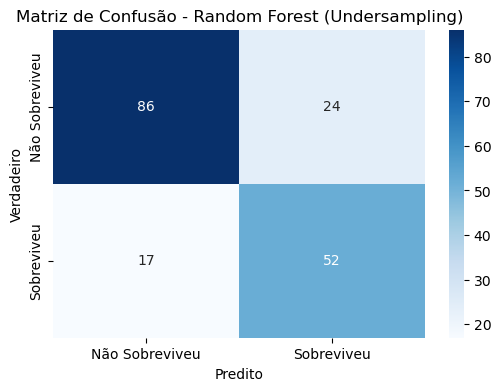

--- Avaliação do Modelo: Random Forest (Oversampling - SMOTE) ---
Acurácia Geral: 0.7989

Relatório de Classificação:
                    precision    recall  f1-score   support

Não Sobreviveu (0)       0.82      0.85      0.84       110
    Sobreviveu (1)       0.75      0.71      0.73        69

          accuracy                           0.80       179
         macro avg       0.79      0.78      0.79       179
      weighted avg       0.80      0.80      0.80       179



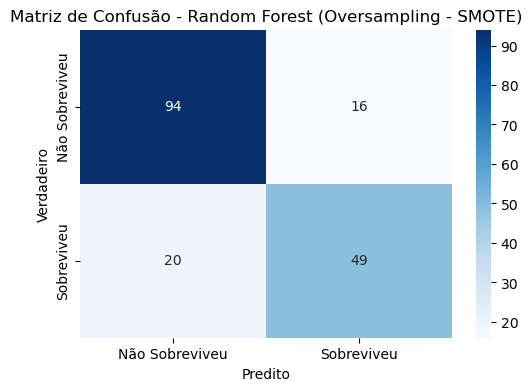

In [16]:

# --- Cenário 1: Modelo com dados Desbalanceados ---
rf_desbalanceado = RandomForestClassifier(n_estimators=100, random_state=42)
rf_desbalanceado.fit(X_train_mf, y_train)
y_pred_desb = rf_desbalanceado.predict(X_test_mf)
evaluate_model("Random Forest (Desbalanceado)", y_test, y_pred_desb)


# --- Cenário 2: Modelo com Undersampling ---
rf_under = RandomForestClassifier(n_estimators=100, random_state=42)
rf_under.fit(X_train_under, y_train_under)
y_pred_under = rf_under.predict(X_test_mf)
evaluate_model("Random Forest (Undersampling)", y_test, y_pred_under)


# --- Cenário 3: Modelo com Oversampling (SMOTE) ---
rf_over = RandomForestClassifier(n_estimators=100, random_state=42)
rf_over.fit(X_train_over, y_train_over)
y_pred_over = rf_over.predict(X_test_mf)
evaluate_model("Random Forest (Oversampling - SMOTE)", y_test, y_pred_over)